In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def merge_excel(path):  #输入路径，得到合并后的数据
    data = pd.DataFrame()
    #data.info()
    #temp_data = pd.DataFrame()
    files = os.listdir(path)
    for i,file in enumerate (files):
        file_path = os.path.join(path,file)
        temp_data = pd.read_excel(file_path,names=None,sheet_name='Sheet1',index_col=None,header=None) #读取excel
        #print(data.shape);print(temp_data.shape)
        data = pd.concat([data,temp_data],axis=0)  #按行合并
    #data.info()
    print(path,"的合并数据大小为： ",data.shape)
    return data

def merge_data(df1,df2):
    merge_df=pd.concat([df1,df2],axis=0)
    print("合并后的有效数据大小为： ",merge_df.shape)
    return merge_df

def process_data(df):
    data=df

    data.drop_duplicates(inplace =True)   #删除重复行数据
    data.rename(columns ={0:'data',1:'ID',2:'name',3:'gender',4:'age',5:'position',
                              6:'Acquisition',7:'registration',8:'x',9:'y',10:'z',11:'comment',12:'other'},inplace =True)
    #data.drop(['registration','data','comment','other'],axis=1,inplace=True)   #删除无用列，不确定拿到后续数据的扩展性，弃用此方法
    #data = data.set_index('data')
    data = data.loc[:,['ID','name','gender','age','position','Acquisition','x','y','z']] #保留想要的列
    info_col = ['ID','name','gender','age','position','Acquisition'] #需补全信息列
    dat_col = ['x','y','z']   #数据列
    data[info_col] = data[info_col].ffill()   #info列填充上一行的非空值，赋值操作，不需要inplace 操作
    
    data = data.groupby('ID').filter(lambda x: len(x)!=1)  #筛选掉所有只有单次的数据
    
    #把x,y,z三列转换为数据类型，不能转成的转为nan，写的文字和角度都被转为999,用作下一步筛选  
    data[dat_col] = data[dat_col].apply(pd.to_numeric, errors='coerce').fillna(999)
    data.loc[(abs(data.x)>0.55)|(abs(data.y)>0.55)|(abs(data.z)>0.55)] = np.nan   #误差＞0.55都重复摆位，转为NaN数据
    data.dropna(inplace = True)                                                   #删除有空值的行，此行数据均为摆位超标数据
    
    #data.info()
    #print("处理后的有效数据大小为： ",data.shape)
    return data

def cal_mean_std(df):
    cal_data = df
    mean_num = [] ; std_num = []
    x_mean = cal_data.groupby(['ID'])['x'].mean().tolist()        #提取x方向的摆位误差均值，按照ID区分不同病人数据,并转为成列表
    mean_num.append(x_mean)
    x_std  = cal_data.groupby(['ID'])['x'].std(ddof=0).tolist()  #提取x方向的摆位误差标准差，ddof=0在pandas中表示求样本标准差
    std_num.append(x_std)
    y_mean = cal_data.groupby(['ID'])['y'].mean().tolist()
    mean_num.append(y_mean)
    y_std = cal_data.groupby(['ID'])['y'].std(ddof=0).tolist()
    std_num.append(y_std)
    z_mean = cal_data.groupby(['ID'])['z'].mean().tolist()
    mean_num.append(z_mean)
    z_std = cal_data.groupby(['ID'])['z'].std(ddof=0).tolist()
    std_num.append(z_std)
    #mean_num 和std_num 长度均为3，包括3个列表，代表X,Y,Z三个方向的数据，其中每个列表的个数代表由多少个不同的ID号也即是病例数
    if len(mean_num[1])<=1 or len(std_num[1])<=1:
        print("数据不足计算！")
        
    print("患者病例数：",len(mean_num[1]))
    #print(mean_num,std_num)
    return mean_num,std_num

def cal_sigma_delta(mean,std):
    sigma = [];delta = []
    for i in range (3):
        sigma.append(np.std(mean[i],ddof = 1));
        delta.append(np.sqrt(np.mean(np.array(std[i])**2)))        
    return sigma,delta

def cal_margin(sigma,delta):
    sigma = 10*np.array(sigma); delta = 10*np.array(delta)
    extend_margin = 2.5*sigma+0.7*np.array(delta)
    print("x方向推荐外放边界为：",round(extend_margin[0],3),"mm")
    print("y方向推荐外放边界为：",round(extend_margin[1],3),"mm")
    print("z方向推荐外放边界为：",round(extend_margin[2],3),"mm")
    return extend_margin

def screen_data(data):
    #data_head = data.groupby('position').filter(lambda x: str(x)=='头部')
    #data_chest = data.groupby('position').filter(lambda x: str(x)=='胸部')
    #data_abdomen = data.groupby('position').filter(lambda x: str(x)=='腹部')
    #data_head=data['position'].str.startswith('头')
    data_head = data.loc[data['position'].str.contains('头|颈|脑|鼻|喉|舌|咽|颌|唇|口|耳|腭|扁桃|腮腺|颞叶|颊|眼|NK|鄂|颅|甲状腺|牙龈|声带|肩|锁骨|枕叶|面部')]
    data_chest = data.loc[data['position'].str.contains('胸|纵隔|肺|食管|乳|腋|肋|支气管|胸部|ESO')]
    data_abdomen = data.loc[data['position'].str.contains('肝|肾|胃|贲门|结肠|小肠|腹')]
    data_pelvis = data.loc[data['position'].str.contains('宫颈|前列腺|直肠|卵巢|精原|髂骨|子宫|盆腔|睾丸|肛|股骨|膀胱|阴茎|阴道|髋')]
    
    #data.info()
    #data_head.info()
    return data_head,data_chest,data_abdomen,data_pelvis

def manual_screen_data(data,params):  #如果输入*params的话 ，就是把输入参数再作为一个元组
    print(params)
    data_screen = pd.DataFrame()
    for param in params:
        print(param)
        data_temp = data.loc[data['position'].str.contains(str(param))]
        data_screen = pd.concat([data_screen,data_temp],axis=0)
    return data_screen

In [3]:
NO_1_path = 'E:\paper\摆位误差分析\一号机CBCT'; NO_3_path ='E:\paper\摆位误差分析\三号机CBCT'
data_1 = merge_excel(NO_1_path)  #合并文件内表格数据，并转为dataframe

data_3 = merge_excel(NO_3_path)
data_origin=merge_data(data_1,data_3)
data_1=process_data(data_1)    #数据预处理

data_3=process_data(data_3)

final_data = merge_data(data_1,data_3)
final_data = process_data(final_data)
print("完整数据大小为： ",final_data.shape)
data_head,data_chest,data_abdomen,data_pelvis = screen_data(final_data)
#print(data.head(10))
print("头颈部肿瘤数据:")
print("数据大小为：",data_head.shape)
mean_num,std_num = cal_mean_std(data_head)    #计算不同患者的摆位误差的平均值和标准差
sigma,delta = cal_sigma_delta(mean_num,std_num)              #计算sigma和delta
cal_margin(sigma,delta);                                              #计算外放边界

print("胸部肿瘤数据:")
print("数据大小为：",data_chest.shape)
mean_num,std_num = cal_mean_std(data_chest)    #计算不同患者的摆位误差的平均值和标准差
sigma,delta = cal_sigma_delta(mean_num,std_num)              #计算sigma和delta
cal_margin(sigma,delta);                                              #计算外放边界

print("腹部肿瘤数据:")
print("数据大小为：",data_abdomen.shape)
mean_num,std_num = cal_mean_std(data_abdomen)    #计算不同患者的摆位误差的平均值和标准差
sigma,delta = cal_sigma_delta(mean_num,std_num)              #计算sigma和delta
cal_margin(sigma,delta);                                              #计算外放边界

print("盆腔肿瘤数据:")
print("数据大小为：",data_pelvis.shape)
mean_num,std_num = cal_mean_std(data_pelvis)    #计算不同患者的摆位误差的平均值和标准差
sigma,delta = cal_sigma_delta(mean_num,std_num)              #计算sigma和delta
cal_margin(sigma,delta);                                              #计算外放边界



E:\paper\摆位误差分析\一号机CBCT 的合并数据大小为：  (8949, 13)
E:\paper\摆位误差分析\三号机CBCT 的合并数据大小为：  (15092, 20)
合并后的有效数据大小为：  (24041, 20)
合并后的有效数据大小为：  (21080, 9)
完整数据大小为：  (21054, 9)
头颈部肿瘤数据:
数据大小为： (6040, 9)
患者病例数： 939
x方向推荐外放边界为： 3.608 mm
y方向推荐外放边界为： 4.738 mm
z方向推荐外放边界为： 3.423 mm
胸部肿瘤数据:
数据大小为： (11315, 9)
患者病例数： 1679
x方向推荐外放边界为： 4.744 mm
y方向推荐外放边界为： 5.707 mm
z方向推荐外放边界为： 3.884 mm
腹部肿瘤数据:
数据大小为： (1629, 9)
患者病例数： 278
x方向推荐外放边界为： 5.012 mm
y方向推荐外放边界为： 5.883 mm
z方向推荐外放边界为： 4.817 mm
盆腔肿瘤数据:
数据大小为： (2708, 9)
患者病例数： 440
x方向推荐外放边界为： 4.688 mm
y方向推荐外放边界为： 6.048 mm
z方向推荐外放边界为： 4.539 mm


In [7]:
cancer = ('乳腺','乳')#,'结肠'  #多个输入的时候整体输入为元组，单一输入的时候单一输入为变量，for循环会分别筛选“直”和“肠”字符

data_define = manual_screen_data(final_data,cancer);
print("%s数据为:%d条"%(cancer,len(data_define.index)))
mean_num,std_num = cal_mean_std(data_define)    #计算不同患者的摆位误差的平均值和标准差
sigma,delta = cal_sigma_delta(mean_num,std_num)              #计算sigma和delta
print('x,y,z的系统误差为：',sigma,'\nx,y,z的随机误差为：',delta)
cal_margin(sigma,delta);                                              #计算外放边界

('乳腺', '乳')
乳腺
乳
('乳腺', '乳')数据为:3128条
患者病例数： 318
x,y,z的系统误差为： [0.16107187688317456, 0.1867039943966518, 0.11582341929274206] 
x,y,z的随机误差为： [0.17032524882209027, 0.178003226022913, 0.11915455794629118]
x方向推荐外放边界为： 5.219 mm
y方向推荐外放边界为： 5.914 mm
z方向推荐外放边界为： 3.73 mm


In [76]:
#保存excel代码段
writer = pd.ExcelWriter(r'E:\paper\摆位误差分析\test\test.xls')
final_data.to_excel(writer,sheet_name = 'Sheet1',index = False)
writer.save()
writer.close()

C:\Users\zlbbme\AppData\Local\Temp/ipykernel_15048/598358901.py:2: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  writer = pd.ExcelWriter(r'E:\paper\摆位误差分析\test\test.xls')


<AxesSubplot:>

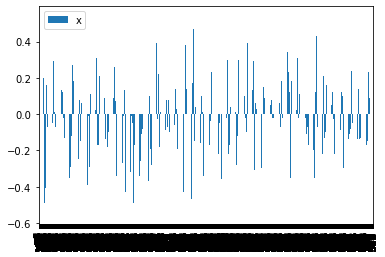

In [4]:
final_data.plot.bar(y='x')


<AxesSubplot:>

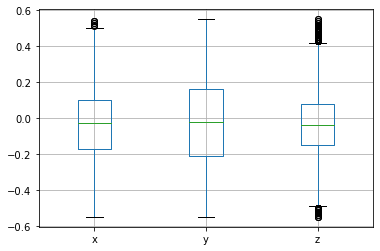

In [8]:
final_data.boxplot()


array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>],
       [<AxesSubplot:title={'center':'z'}>, <AxesSubplot:>]], dtype=object)

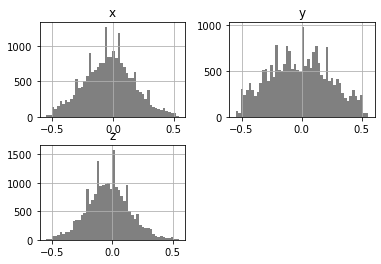

In [16]:
# 绘制多子图
final_data.hist(color="gray", bins=50)#, alpha=0.5


<AxesSubplot:>

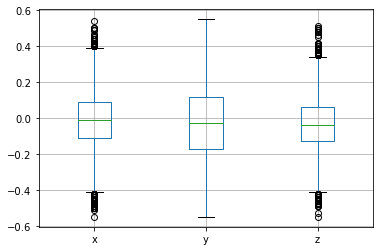

In [17]:
data_head.boxplot()

In [3]:
#摆位数据录入
error_path = r'E:\paper\摆位误差分析\test\摆位有效数据.xls'
error_data = pd.read_excel(error_path,names=None,sheet_name='Sheet1',index_col= None,header=0)
error_data.sort_values('ID', ascending=True,inplace = True)
error_data.set_index('ID')
error_data = error_data.loc[:,['ID','name','gender','age','position','x','y','z']]

In [4]:
#登记数据录入
regs_path = r'E:\paper\摆位误差分析\test\登记数据.xlsx'
regs_data = pd.read_excel(regs_path,names=None,sheet_name='合并',index_col= None,header=None)
regs_data.drop([0],inplace = True)
regs_data.rename(columns ={0:'data',1:'ID',2:'name',3:'gender',4:'age',5:'part',
                              6:'disease',7:'doctor',8:'height',9:'weight'},inplace =True)

In [6]:
#录入BMI数据
#regs_data.drop(['data','part','doctor'],axis = 1,inplace = True)   #删除指定列
bmi_info = regs_data[['ID','height','weight']]
bmi_info['ID'] = bmi_info.loc[:,'ID'].apply(pd.to_numeric, errors='coerce')#.fillna(999)
bmi_info.dropna(inplace = True)
bmi_info.sort_values('ID', ascending=True,inplace = True)
bmi_info

C:\Users\zlbbme\AppData\Local\Temp/ipykernel_1572/4228198320.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bmi_info['ID'] = bmi_info.loc[:,'ID'].apply(pd.to_numeric, errors='coerce')#.fillna(999)
C:\Users\zlbbme\AppData\Local\Temp/ipykernel_1572/4228198320.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bmi_info.dropna(inplace = True)
C:\Users\zlbbme\AppData\Local\Temp/ipykernel_1572/4228198320.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org

,ID,height,weight
819,2.020072e+08,168,58
466,2.020507e+08,165,76
513,2.020515e+08,153,52
4782,2.011121e+09,148,61.5
2594,2.012122e+09,160,48.5
...,...,...,...
5331,2.022081e+09,152,42
5332,2.022081e+09,162,50
5333,2.022081e+09,160,54
5334,2.022081e+09,152,54


In [11]:
error_bmi = error_data.merge(bmi_info, left_on='ID', right_on='ID', how='inner')
error_bmi.sort_values('ID', ascending=True,inplace = True)
#error_data.join(diseases)
error_bmi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28623 entries, 0 to 28622
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        28623 non-null  int64  
 1   name      28623 non-null  object 
 2   gender    28623 non-null  object 
 3   age       28623 non-null  object 
 4   position  28623 non-null  object 
 5   x         28623 non-null  float64
 6   y         28623 non-null  float64
 7   z         28623 non-null  float64
 8   height    28623 non-null  object 
 9   weight    28623 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 2.4+ MB


In [9]:
#整合定位的ID号和诊断信息
sim2020_path = r'E:\paper\摆位误差分析\test\2020年定位记录表.xlsx'
sim_2020 = pd.read_excel(sim2020_path,names=None,sheet_name='定位',index_col= None,header=None)
sim_2020.drop([0],inplace = True)
sim_2020.rename(columns ={0:'data',1:'ID',2:'name',3:'gender',4:'age',5:'part',
                              6:'no.1',7:'no.2',8:'disease',9:'weight'},inplace =True)
t_2020 = sim_2020[['ID','disease']]
#t_2020.info()

sim2021_path = r'E:\paper\摆位误差分析\test\2021年定位记录表.xlsx'
sim_2021 = pd.read_excel(sim2021_path,names=None,sheet_name='定位',index_col= None,header=None)
sim_2021.drop([0],inplace = True)
sim_2021.rename(columns ={0:'data',1:'ID',2:'name',3:'gender',4:'age',5:'part',
                              6:'no.1',7:'no.2',8:'disease',9:'weight'},inplace =True)
t_2021 = sim_2021[['ID','disease']]
#t_2021.drop([0],inplace = True)
sim_all = pd.concat([t_2020,t_2021],axis=0)
#t_2021.info()

sim2022_path = r'E:\paper\摆位误差分析\test\2022年定位记录表.xlsx'
sim_2022 = pd.read_excel(sim2022_path,names=None,sheet_name='定位',index_col= None,header=None)
sim_2022.drop([0],inplace = True)
sim_2022.rename(columns ={0:'data',1:'ID',2:'name',3:'gender',4:'age',5:'part',
                              6:'no.1',7:'no.2',8:'disease',9:'weight'},inplace =True)
t_2022 = sim_2022[['ID','disease']]
#t_2022.drop([0],inplace = True)
#t_2022.info()
sim_all = pd.concat([sim_all,t_2022],axis=0)


In [10]:
sim_all['ID'] = sim_all['ID'].apply(pd.to_numeric, errors='coerce')
sim_all.dropna(inplace = True)
sim_all.sort_values('ID', ascending=True,inplace = True)
sim_all

,ID,disease
203,2.020122e+08,鼻咽恶性肿瘤，肺继发恶性肿瘤
1313,2.020918e+08,原发性肝癌
891,2.011121e+09,食管恶性肿瘤放疗后复发
641,2.012122e+09,舌恶性肿瘤
879,2.012122e+09,舌恶性肿瘤
...,...,...
1499,2.022081e+09,食管恶性肿瘤
1427,2.022082e+09,结肠恶性肿瘤
999,2.020073e+10,肺恶性肿瘤颅继发恶性肿瘤
1229,2.020090e+10,右肺上叶腺癌术后 右侧胸膜继发恶性肿瘤


In [17]:
error_bmi_sim = error_bmi.merge(sim_all, left_on='ID', right_on='ID', how='inner')
error_bmi_sim.drop_duplicates(inplace =True) 
error_bmi_sim

D:\DeepLearning\lib\site-packages\pandas\core\reshape\merge.py:1219: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  warnings.warn(


,ID,name,gender,age,position,x,y,z,height,weight,disease
0,2011121204,杨明芬,女,74,食管癌,-0.14,0.10,0.02,148,61.5,食管恶性肿瘤放疗后复发
1,2011121204,杨明芬,女,74,食管癌,-0.04,-0.45,-0.22,148,61.5,食管恶性肿瘤放疗后复发
2,2011121204,杨明芬,女,74,食管癌,0.08,-0.36,-0.08,148,61.5,食管恶性肿瘤放疗后复发
3,2011121204,杨明芬,女,74,食管癌,0.00,-0.01,-0.05,148,61.5,食管恶性肿瘤放疗后复发
4,2011121204,杨明芬,女,74,食管癌,-0.11,-0.45,0.03,148,61.5,食管恶性肿瘤放疗后复发
...,...,...,...,...,...,...,...,...,...,...,...
52311,2022071206,谭明付,男,67,肺癌伴骨转移,-0.37,-0.21,0.17,157,49.5,右肺上叶恶性肿瘤，骨继发恶性肿瘤
52312,2022071206,谭明付,男,67,肺癌伴骨转移,0.15,-0.23,0.14,157,49.5,右肺上叶恶性肿瘤，骨继发恶性肿瘤
52313,2022071206,谭明付,男,67,肺癌伴骨转移,0.13,-0.05,0.00,157,49.5,右肺上叶恶性肿瘤，骨继发恶性肿瘤
52314,2022071404,张绍六,男,54,食管癌,0.08,-0.02,-0.10,169,63.6,食管恶性肿瘤


In [18]:
error_bmi_sim.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32740 entries, 0 to 52315
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        32740 non-null  int64  
 1   name      32740 non-null  object 
 2   gender    32740 non-null  object 
 3   age       32740 non-null  object 
 4   position  32740 non-null  object 
 5   x         32740 non-null  float64
 6   y         32740 non-null  float64
 7   z         32740 non-null  float64
 8   height    32740 non-null  object 
 9   weight    32740 non-null  object 
 10  disease   32740 non-null  object 
dtypes: float64(3), int64(1), object(7)
memory usage: 3.0+ MB


In [28]:
error_bmi_sim.drop_duplicates(['ID','name','x','y','z'],keep = 'first',inplace = True) 

In [29]:
error_bmi_sim.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18121 entries, 0 to 52315
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        18121 non-null  int64  
 1   name      18121 non-null  object 
 2   gender    18121 non-null  object 
 3   age       18121 non-null  object 
 4   position  18121 non-null  object 
 5   x         18121 non-null  float64
 6   y         18121 non-null  float64
 7   z         18121 non-null  float64
 8   height    18121 non-null  object 
 9   weight    18121 non-null  object 
 10  disease   18121 non-null  object 
dtypes: float64(3), int64(1), object(7)
memory usage: 1.7+ MB


In [30]:
#保存excel代码段
writer = pd.ExcelWriter(r'E:\paper\摆位误差分析\test\final_error_bmi_sim_final.xls')
error_bmi_sim.to_excel(writer,sheet_name = 'Sheet1',index = False)
writer.save()
writer.close()

C:\Users\zlbbme\AppData\Local\Temp/ipykernel_1572/721508561.py:2: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  writer = pd.ExcelWriter(r'E:\paper\摆位误差分析\test\final_error_bmi_sim_final.xls')


In [33]:
error_bmi_sim.groupby('ID').count()

,name,gender,age,position,x,y,z,height,weight,disease
ID,,,,,,,,,,
2011121204,8,8,8,8,8,8,8,8,8,8
2012122101,9,9,9,9,9,9,9,9,9,9
2013052204,6,6,6,6,6,6,6,6,6,6
2013083002,8,8,8,8,8,8,8,8,8,8
2013101603,7,7,7,7,7,7,7,7,7,7
...,...,...,...,...,...,...,...,...,...,...
2022070801,4,4,4,4,4,4,4,4,4,4
2022070803,3,3,3,3,3,3,3,3,3,3
2022070805,2,2,2,2,2,2,2,2,2,2


In [38]:
error_bmi_sim[['height','weight']] = error_bmi_sim[['height','weight']].apply(pd.to_numeric, errors='coerce') 
error_bmi_sim.eval('bmi = weight/(height/100)',inplace = True)#, inplace=True

In [39]:
#保存excel代码段
writer = pd.ExcelWriter(r'E:\paper\摆位误差分析\test\final_error_bmi_sim_cal.xls')
error_bmi_sim.to_excel(writer,sheet_name = 'Sheet1',index = False)
writer.save()
writer.close()

C:\Users\zlbbme\AppData\Local\Temp/ipykernel_1572/3276303867.py:2: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  writer = pd.ExcelWriter(r'E:\paper\摆位误差分析\test\final_error_bmi_sim_cal.xls')


In [4]:
path = r'E:\paper\摆位误差分析\test\final_error_bmi_sim_cal.xls'
error_bmi_sim = pd.read_excel(path,names=None,sheet_name='Sheet1',index_col= None,header=0)
final_lung = error_bmi_sim.loc[error_bmi_sim['disease'].str.contains('肺')]

In [5]:
final_lung.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5040 entries, 17 to 18118
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        5040 non-null   int64  
 1   name      5040 non-null   object 
 2   gender    5040 non-null   object 
 3   age       5040 non-null   object 
 4   position  5040 non-null   object 
 5   x         5040 non-null   float64
 6   y         5040 non-null   float64
 7   z         5040 non-null   float64
 8   height    5032 non-null   float64
 9   weight    5007 non-null   float64
 10  disease   5040 non-null   object 
 11  bmi       4999 non-null   float64
dtypes: float64(6), int64(1), object(5)
memory usage: 511.9+ KB


In [7]:
final_lung.dropna(inplace = True)
final_lung.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4999 entries, 17 to 18118
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        4999 non-null   int64  
 1   name      4999 non-null   object 
 2   gender    4999 non-null   object 
 3   age       4999 non-null   object 
 4   position  4999 non-null   object 
 5   x         4999 non-null   float64
 6   y         4999 non-null   float64
 7   z         4999 non-null   float64
 8   height    4999 non-null   float64
 9   weight    4999 non-null   float64
 10  disease   4999 non-null   object 
 11  bmi       4999 non-null   float64
dtypes: float64(6), int64(1), object(5)
memory usage: 507.7+ KB


C:\Users\zlbbme\AppData\Local\Temp/ipykernel_6692/3365821190.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_lung.dropna(inplace = True)


In [8]:
#保存excel代码段
writer = pd.ExcelWriter(r'E:\paper\摆位误差分析\test\final_lung.xls')
final_lung.to_excel(writer,sheet_name = 'Sheet1',index = False)
writer.save()
writer.close()

C:\Users\zlbbme\AppData\Local\Temp/ipykernel_6692/586107632.py:2: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  writer = pd.ExcelWriter(r'E:\paper\摆位误差分析\test\final_lung.xls')


In [25]:
path = r'E:\paper\摆位误差分析\test\final_lung.xls'
final_lung = pd.read_excel(path,names=None,sheet_name='Sheet1',index_col= None,header=0)

In [15]:
final_lung.eval('bmi = weight/((height/100)**2)',inplace = True)
final_lung

,ID,name,gender,age,position,x,y,z,height,weight,disease,bmi
0,2020110204,梁义辉,男,68,肺,-0.49,0.36,0.04,160,67.0,左肺恶性肿瘤,26.171875
1,2020110204,梁义辉,男,67,左肺,0.11,-0.46,-0.29,160,67.0,左肺恶性肿瘤,26.171875
2,2022010606,谢忠余,男,80,肺癌,-0.01,-0.18,-0.07,165,55.0,右肺小细胞肺癌,20.202020
3,2022010606,谢忠余,男,80,肺癌,-0.05,0.15,-0.01,165,55.0,右肺小细胞肺癌,20.202020
4,2022010606,谢忠余,男,80,肺癌,-0.02,-0.13,0.32,165,55.0,右肺小细胞肺癌,20.202020
...,...,...,...,...,...,...,...,...,...,...,...,...
4994,2022021503,谭明正,男,52,左肺,0.22,0.00,0.09,179,73.0,左肺小细胞肺癌,22.783309
4995,2022021503,谭明正,男,52,左肺,-0.10,0.45,0.03,179,73.0,左肺小细胞肺癌,22.783309
4996,2017080108,陈仕珍,女,69,肺癌颈部转移,-0.21,0.16,-0.07,153,52.0,右肺恶性肿瘤放疗后，纵隔、骨、肝直肠继发恶性肿瘤,22.213678
4997,2017080108,陈仕珍,女,68,右肺,0.21,0.36,0.13,153,52.0,右肺恶性肿瘤放疗后，纵隔、骨、肝直肠继发恶性肿瘤,22.213678


In [17]:
final_lung.sort_values('ID', ascending=True,inplace = True)

In [18]:
#保存excel代码段
writer = pd.ExcelWriter(r'E:\paper\摆位误差分析\test\final_lung.xls')
final_lung.to_excel(writer,sheet_name = 'Sheet1',index = False)
writer.save()
writer.close()

C:\Users\zlbbme\AppData\Local\Temp/ipykernel_6692/586107632.py:2: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  writer = pd.ExcelWriter(r'E:\paper\摆位误差分析\test\final_lung.xls')


In [20]:
#摆位登记病种和定位登记病种
final_lung = final_lung.loc[final_lung['disease'].str.contains('肺') & final_lung['position'].str.contains('肺|胸')]

In [21]:
final_lung.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3614 entries, 4566 to 1126
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        3614 non-null   int64  
 1   name      3614 non-null   object 
 2   gender    3614 non-null   object 
 3   age       3614 non-null   object 
 4   position  3614 non-null   object 
 5   x         3614 non-null   float64
 6   y         3614 non-null   float64
 7   z         3614 non-null   float64
 8   height    3614 non-null   int64  
 9   weight    3614 non-null   float64
 10  disease   3614 non-null   object 
 11  bmi       3614 non-null   float64
dtypes: float64(5), int64(2), object(5)
memory usage: 367.0+ KB


In [22]:
writer = pd.ExcelWriter(r'E:\paper\摆位误差分析\test\final_lung.xls')
final_lung.to_excel(writer,sheet_name = 'Sheet1',index = False)
writer.save()
writer.close()

C:\Users\zlbbme\AppData\Local\Temp/ipykernel_6692/2731089637.py:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  writer = pd.ExcelWriter(r'E:\paper\摆位误差分析\test\final_lung.xls')


In [5]:
final_lung.groupby('ID').count()

,name,gender,age,position,x,y,z,height,weight,disease,bmi
ID,,,,,,,,,,,
2015051802,10,10,10,10,10,10,10,10,10,10,10
2015081204,6,6,6,6,6,6,6,6,6,6,6
2016051301,7,7,7,7,7,7,7,7,7,7,7
2016122004,5,5,5,5,5,5,5,5,5,5,5
2017030103,6,6,6,6,6,6,6,6,6,6,6
...,...,...,...,...,...,...,...,...,...,...,...
2022062104,5,5,5,5,5,5,5,5,5,5,5
2022062206,5,5,5,5,5,5,5,5,5,5,5
2022070404,4,4,4,4,4,4,4,4,4,4,4


In [6]:
mean_num,std_num = cal_mean_std(final_lung)    #计算不同患者的摆位误差的平均值和标准差
sigma,delta = cal_sigma_delta(mean_num,std_num)              #计算sigma和delta
cal_margin(sigma,delta);                                              #计算外放边界

患者病例数： 513
x方向推荐外放边界为： 4.594 mm
y方向推荐外放边界为： 5.293 mm
z方向推荐外放边界为： 3.92 mm


In [90]:
path = r'E:\paper\摆位误差分析\test\final_lung.xls'
final_lung = pd.read_excel(path,names=None,sheet_name='Sheet1',index_col= None,header=0)

In [91]:
final_lung['age'] = final_lung['age'].apply(pd.to_numeric, errors='coerce')
age_list = final_lung.groupby('ID')['age'].mean().tolist()#['age']

In [92]:
np.min(age_list)

36.0

In [97]:
lung_male = final_lung.loc[(final_lung['gender'].str.contains('男'))]#.tolist(),'ID'
lung_female = final_lung.loc[(final_lung['gender'].str.contains('女'))]#.tolist(),'ID'

In [96]:
#print(set(male_ID)&set(female_ID))  #转化成集合求交集
print(set(lung_male)&set(lung_female))

set()


In [98]:
lung_male.groupby('ID').count()

,name,gender,age,position,x,y,z,height,weight,disease,bmi
ID,,,,,,,,,,,
2015051802,10,10,10,10,10,10,10,10,10,10,10
2016051301,7,7,7,7,7,7,7,7,7,7,7
2016122004,5,5,5,5,5,5,5,5,5,5,5
2017030103,6,6,6,6,6,6,6,6,6,6,6
2018030507,6,6,6,6,6,6,6,6,6,6,6
...,...,...,...,...,...,...,...,...,...,...,...
2022062102,4,4,4,4,4,4,4,4,4,4,4
2022062104,5,5,5,5,5,5,5,5,5,5,5
2022062206,5,5,5,5,5,5,5,5,5,5,5


In [99]:
lung_female.groupby('ID').count()

,name,gender,age,position,x,y,z,height,weight,disease,bmi
ID,,,,,,,,,,,
2015081204,6,6,6,6,6,6,6,6,6,6,6
2017080108,6,6,6,6,6,6,6,6,6,6,6
2018012501,15,15,15,15,15,15,15,15,15,15,15
2018052804,5,5,5,5,5,5,5,5,5,5,5
2018120707,8,8,8,8,8,8,8,8,8,8,8
...,...,...,...,...,...,...,...,...,...,...,...
2022060602,6,6,6,6,6,6,6,6,6,6,6
2022060606,5,5,5,5,5,5,5,5,5,5,5
2022060802,7,7,7,7,7,7,7,7,7,7,7
